# Drivers of Reddit NBA sentiment
This notebook investigates what drives the sentiment of NBA players on reddit. It roughly has N parts:
1. Building a set of covariates for sentiment (e.g. player demographics, city demographics, performance data)
2. Calculating the sentiment towards each player
3. Performing a regression model to predict player sentiment

This is a work in progress. For similar work on the NFL, see `nfl-sentiment.ipynb`.

For the most fun, I would skip to **Exploration of sentiment values**

### Weekend to-do:
Fuzzy match comments to coaches
Re-factor notebooks into
1. Scraping and covariates
2. Sentiment analysis
3. Regression

### Long term to-do:
Create functions for:
  * fuzzy matching cleanup
  * aggregation (maybe)

Get Twitter data for comparison

In [1]:
import json
import string
import re
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from ast import literal_eval
from string import punctuation
from sner import Ner
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
import sports_sentiment as ss
import scrape_player_data as spd

In [3]:
# download stanford core nlp (should be a zip file of format stanford-ner-YYYY-MM-DD) (maybe from https://nlp.stanford.edu/software/CRF-NER.shtml#Download)
# need to start the Java server:
# cd C:\ProgramData\Anaconda3\Lib\site-packages\sner\stanford-ner-2018-02-27
# java -Djava.ext.dirs=./lib -cp stanford-ner.jar edu.stanford.nlp.ie.NERServer -port 9199 -loadClassifier ./classifiers/english.all.3class.distsim.crf.ser.gz  -tokenizerFactory edu.stanford.nlp.process.WhitespaceTokenizer -tokenizerOptions tokenizeNLs=false
# for entity-sentiment c:\ProgramData\Anaconda3\Lib\site-packages\stanford-corenlp\stanford-corenlp-full-2018-10-05
from pycorenlp import StanfordCoreNLP

In [4]:
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_columns', 100)

## Constants and non-text data

In [5]:
non_players_set = set('Atlanta Hawks Boston Celtics Brooklyn Nets Charlotte Bobcats ' \
                  'Chicago Bulls Cleveland Cavaliers cavs Dallas Mavericks mavs Denver Nuggets ' \
                  'Detroit Pistons Golden State Warriors Houston Rockets Indiana '\
                  'Pacers Los Angeles LA Clippers LA Lakers LAL Memphis Grizzlies Miami Heat '\
                  'Milwaukee Bucks Minnesota Timberwolves  New Orleans Hornets New York Knicks NYK '\
                  'Oklahoma City Thunder Orlando Magic Philadelphia Sixers 76ers Phoenix '\
                  'Suns Portland Trail Blazers Sacramento Kings '\
                  'San Antonio Spurs Toronto Raptors Utah Jazz Washington Wizards wiz '\
                      'NBA asg KOC woj shams'.lower().split())

In [39]:
coaches_df = pd.read_csv('d:/data/sentiment_sports/covariates/nba_coach_performance.tsv', sep='\t')
coaches_race_df = pd.read_csv('d:/data/sentiment_sports/covariates/nba_coach_race.tsv', sep='\t')
coaches = set([name for coach in list(coaches_race_df.iloc[:,0]) for name in coach.split(' ')] )

### Instantiate sentiment analyzer
For sentiment, I use a modified version of VADER. Many words have different sentiment in the sports world as compared to general usage (e.g. "offensive" is not a negative word in sports).

In [7]:
sid = SentimentIntensityAnalyzer()
stat_words = ['steal', 'steals', 'block', 'blocked', 'blocks', 'slam', 'charges', 'rejection', 'free', 'assists', 'win']
neutral_words = ['offense', 'offensive', 'offensively', 'defense', 'defensive', 'defensively', 'defender',
                 'injury', 'injured', 'strain', 'questionable', 'isolation',
                 'shoot', 'doubtful', 'play', 'plays', 'crazy', 'turnover', 'turnovers',
                 'seriously', 'loss', 'losses', 'playing', 'vicious',]
bad_words = ['foul', 'ridiculous', 'motherfucking', 'mediocre', 'soft', 'slow', 'delusional']
great_words = ['goat', 'nasty', 'prime', 'mvp']
sid.lexicon.update({word:0.1 for word in stat_words})
sid.lexicon.update({word:0 for word in neutral_words})
sid.lexicon.update({word:-0.5 for word in bad_words})
sid.lexicon.update({word:1 for word in great_words})

#### Player names for entity recognition and fuzzy matching
When extracting named entities, I had to be careful with some names that are common English words (e.g. "Brown"). As a shorter alternative to performing NER, I also sometimes simply extracted player names as keywords.

In [36]:
covariates_df = pd.read_csv('d:/data/sentiment_sports/covariates/nba_player_covariates.tsv', sep='\t')
covariates_df.head(2)

,Player,Race,From,To,Pos_x,Ht,Wt,Birth Date,Colleges,Rk,Pos_y,Age,G,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRBP,ASTP,STLP,BLKP,TOVP,USG%,Unnamed: 19,OWS,DWS,WS,WS/48,Unnamed: 24,OBPM,DBPM,BPM,VORP,Tm,FG,FGA,FG%,3P,3PA,ThreePP,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PPG,year,season,Wins,total_population,metro_percent_white,metro_percent_black,clinton_vote_lead,salary,standard_salary,experience
0,alex abrines,W,2017,2018,G-F,78,190,"August 1, 1993",NaN,1,SG,23,68,1055,10.1,0.560,0.724,0.144,1.9,7.1,4.5,5.5,1.7,0.6,8.3,15.9,NaN,1.2,0.9,2.1,0.096,NaN,-0.3,-2.2,-2.5,-0.1,OKC,2.0,5.0,0.393,1.4,3.6,0.381,0.6,1.4,0.426,0.531,0.6,0.7,0.898,0.3,1.0,1.3,0.6,0.5,0.1,0.5,1.7,6.0,2017,2016,47,1337075,74.1,10.2,0.1051,5994764.0,49.481519,0
1,steven adams,W,2014,2018,C,84,255,"July 20, 1993",University of Pittsburgh,3,C,23,80,2389,16.5,0.589,0.002,0.392,13.0,15.4,14.2,5.4,1.8,2.6,16.0,16.2,NaN,3.3,3.1,6.5,0.130,NaN,-0.7,1.2,0.6,1.5,OKC,4.7,8.2,0.571,0.0,0.0,0.000,4.7,8.2,0.572,0.571,2.0,3.2,0.611,3.5,4.2,7.7,1.1,1.1,1.0,1.8,2.4,11.3,2017,2016,47,1337075,74.1,10.2,0.1051,3140517.0,42.096917,3


In [37]:
UNIQUE_NAMES = set(covariates_df.Player.unique())
UNIQUE_NAMES = UNIQUE_NAMES.union(set(coaches_race_df.iloc[:,0]))

In [38]:
NAMED_ENTITIES = set(' '.join(UNIQUE_NAMES).split()).union({'lma', 'kd', 'lbj', 'klove', 'drose', 'kobe',
                                                            'mj', 'magic', 'bird', 'wilt', 'chamberlain',
                                                            'tt', 'shump', 'kat', 'melo', 'k-love', 'd-wade',
                                                            'boogie', 'bosh', 'iggy'})
# some players have common word names; don't want to detect those as entities when lowercase, but do want to when uppercase
UPPER_ENTITIES = {'Black', 'Ball', 'Brown', 'Buddy', 'Grant', 'House', 'Smart', 'Holiday', 'Love', 'Rose', 'Smart', 'Stone','Temple', 
                  'Wall', 'Will', 'White', 'Wear', 'Case', 'New', 'Little', 'Shorts', 'City', 'Will', 'Young', 'Blue', 'Gay', 'Price'}
NAMED_ENTITIES = NAMED_ENTITIES - {'a'} - {name.lower() for name in UPPER_ENTITIES}
table = str.maketrans({key: None for key in string.punctuation})
NOPUNCT_ENTITIES = {name.translate(table) for name in NAMED_ENTITIES}
NAMED_ENTITIES = NAMED_ENTITIES.union(NOPUNCT_ENTITIES)
NAMED_ENTITIES = NAMED_ENTITIES.union(non_players_set)
NAMED_ENTITIES = NAMED_ENTITIES.union(coaches)

### Load covariates

In [ ]:
def create_month_df(data_loc):
    return ss.create_sentiment_df(data_loc, sid.polarity_scores, ner_set=NAMED_ENTITIES,
                                  non_players_set=non_players_set, UPPER_NAMES = UPPER_ENTITIES)

## Calculate sentiment 
### Reddit sentiment for 2017-18 season
I created a module, `sentiment_sports` to calculate the sentiment of comments. This function performs a few things:
1. Separates comments into sentences
2. Performs Named entity recognition using either NLTK, or using pre-existing list of entities
3. Calculates sentiment using VADER with a modified lexicon

In [ ]:
%%time
file_stub = 'd:/data/sentiment_sports/nba_reddit_comments/{}-comments_submissions.tsv.gz'
_, oct_df = create_month_df(file_stub.format(201710))
_, nov_df = create_month_df(file_stub.format(201711))
_, dec_df = create_month_df(file_stub.format(201712))
_, jan_df = create_month_df(file_stub.format(201801))
_, feb_df = create_month_df(file_stub.format(201802))
_, mar_df = create_month_df(file_stub.format(201803))
_, apr_df = create_month_df(file_stub.format(201804))
_, may_df = create_month_df(file_stub.format(201805))

In [57]:
nba2017_df = pd.concat([oct_df, nov_df, dec_df, jan_df, feb_df, mar_df, apr_df, may_df])
nba2017_df.shape

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  """Entry point for launching an IPython kernel.


(1287763, 16)

In [58]:
%%time
nba2017_df = ss.fuzzy_match_players(nba2017_df, UNIQUE_NAMES)

Fuzzy matching player names
Wall time: 3min 25s


In [70]:
nba2017_df.to_csv('d:/data/sentiment_sports/combined_months_ner_sentiment_2017.tsv', sep='\t',
               index=False, encoding = 'utf-8')

#### 2016 season

In [ ]:
%%time
file_stub = 'd:/data/sentiment_sports/nba_reddit_comments/{}-comments_submissions.tsv'
_, oct_df = create_month_df(file_stub.format(201610))
_, nov_df = create_month_df(file_stub.format(201611))
_, dec_df = create_month_df(file_stub.format(201612))
_, jan_df = create_month_df(file_stub.format(201701))
_, feb_df = create_month_df(file_stub.format(201702) + '.gz')
_, mar_df = create_month_df(file_stub.format(201703) + '.gz')
_, apr_df = create_month_df(file_stub.format(201704) + '.gz')
_, may_df = create_month_df(file_stub.format(201705) + '.gz')

In [72]:
nba2016_df = pd.concat([oct_df, nov_df, dec_df, jan_df, feb_df, mar_df, apr_df, may_df])
nba2016_df.shape
# previously 888k

(879282, 15)

In [73]:
nba2016_df = ss.fuzzy_match_players(nba2016_df, UNIQUE_NAMES)

Fuzzy matching player names


In [74]:
nba2016_df.to_csv('d:/data/sentiment_sports/combined_months_ner_sentiment_2016.tsv', sep='\t',
               index=False, encoding = 'utf-8')

#### 2015 season

In [ ]:
%%time
file_stub = 'd:/data/sentiment_sports/nba_reddit_comments/{}-comments_submissions.tsv'
_, oct_df = create_month_df(file_stub.format(201510))
_, nov_df = create_month_df(file_stub.format(201511))
_, dec_df = create_month_df(file_stub.format(201512))
_, jan_df = create_month_df(file_stub.format(201601))
_, feb_df = create_month_df(file_stub.format(201602))
_, mar_df = create_month_df(file_stub.format(201603))
_, apr_df = create_month_df(file_stub.format(201604))
_, may_df = create_month_df(file_stub.format(201605))

In [77]:
nba2015_df = pd.concat([oct_df, nov_df, dec_df, jan_df, feb_df, mar_df, apr_df, may_df])
nba2015_df.shape
#945k using old way

(736950, 15)

In [78]:
nba2015_df = ss.fuzzy_match_players(nba2015_df, UNIQUE_NAMES)

Fuzzy matching player names


In [79]:
nba2015_df.to_csv('d:/data/sentiment_sports/combined_months_ner_sentiment_2015.tsv', sep='\t',
               index=False, encoding = 'utf-8')

#### 2014 season

In [ ]:
%%time
file_stub = 'd:/data/sentiment_sports/nba_reddit_comments/{}-comments_submissions.tsv'
#_, oct_df = create_month_df(file_stub.format(201410))
_, nov_df = create_month_df(file_stub.format(201411))
_, dec_df = create_month_df(file_stub.format(201412))
_, jan_df = create_month_df(file_stub.format(201501))
_, feb_df = create_month_df(file_stub.format(201502))
_, mar_df = create_month_df(file_stub.format(201503))
_, apr_df = create_month_df(file_stub.format(201504))
_, may_df = create_month_df(file_stub.format(201505))

In [146]:
nba2014_df = pd.concat([nov_df, dec_df, jan_df, feb_df, mar_df, apr_df, may_df])
nba2014_df.shape

(833585, 15)

In [147]:
nba2014_df = ss.fuzzy_match_players(nba2014_df, UNIQUE_NAMES)

Fuzzy matching player names


In [148]:
nba2014_df.to_csv('d:/data/sentiment_sports/combined_months_ner_sentiment_2014.tsv', sep='\t',
               index=False, encoding = 'utf-8')

### Load comment sentiment data

In [9]:
nba2014_df = pd.read_csv('d:/data/sentiment_sports/combined_months_ner_sentiment_2014.tsv',sep='\t', encoding = 'utf-8')
nba2014_df['named_entities'] = nba2014_df['named_entities'].apply(literal_eval)
nba2015_df = pd.read_csv('d:/data/sentiment_sports/combined_months_ner_sentiment_2015.tsv',sep='\t', encoding = 'utf-8')
nba2015_df['named_entities'] = nba2015_df['named_entities'].apply(literal_eval)
nba2016_df = pd.read_csv('d:/data/sentiment_sports/combined_months_ner_sentiment_2016.tsv',sep='\t', encoding = 'utf-8')
nba2016_df['named_entities'] = nba2016_df['named_entities'].apply(literal_eval)
nba2017_df = pd.read_csv('d:/data/sentiment_sports/combined_months_ner_sentiment_2017.tsv',sep='\t', encoding = 'utf-8').drop(columns='Unnamed: 0')
nba2017_df['named_entities'] = nba2017_df['named_entities'].apply(literal_eval)

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (1,2,4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
nba2014_df['season'] = 2014
nba2015_df['season'] = 2015
nba2016_df['season'] = 2016
nba2017_df['season'] = 2017

#### Cleaning up name matches
Some extracted name entities don't have a clear match (e.g. "Rivers" could be Austin Rivers or Doc Rivers). Here we clean those out

In [11]:
name_map = {name:'unclear' for name in ['rivers', 'bird', 'draymond sessions', 'jalen jalen', 'brown markelle', 'kyrie korver', 'kyrie singler',
                    'wade drummond', 'kyrie anderson', 'kyle irving', 'kyle ingles', 'kyle turner', 'kyle turner', 'jabari maker',
                    'walton walton', 'nene kanter', 'courtney love', 'george will', 'charles charles', 'jason aaron', 'lebron jae',
                    'sterling lebron', 'bobby lebron', 'damien', 'cleveland', 'cleveland cleveland', 'ben ben', 'martin', "o'bryant",
                                       'sam sam', 'shaquille shaquille', 'blue', 'jamal curry', 'david westbrook', 'griffin baker', 'chris pau',
                                       'jimmy tyler', 'jamal curry', 'jamal curry' 'london','jackson tatum', 'ball', 'early', 'phil', 'world', 'peace',
                                        'wilt', 'wallace']}
name_map.update({'giannis':'giannis antetokounmpo', 'kd':'kevin durant', 'kd kd': 'kevin durant',
                 'lbj':'lebron james', 'lma':'lamarcus aldridge', 
                 'shump': 'iman shumpert', 'blake': 'blake griffin',
                 'kat': 'karl-anthony towns', 'dwight': 'dwight howard',
                 'boogie':'demarcus cousins', 'demar': 'demar derozan',
                'klove':'kevin love', 'cj': 'cj mccollum', 'shabazz': 'shabazz muhammad',
                'ingram': 'brandon ingram', 'manu': 'manu ginobili', 'thon': 'thon maker',
                'simmons': 'ben simmons', 'ben': 'ben simmons', 'jj':'jj redick',
                'wade': 'dwyane wade', 'wall': 'john wall', 'nance jr': 'larry nance', 'pau':'pau gasol',
                 'mbah moute': 'luc mbah a moute', 'luc': 'luc mbah a moute',
                'lin': 'jeremy lin', 'iggy':'andre iguodala', 'lue':'tyronn lue', 'tt':'tristan thompson',
                'hayward': 'gordon hayward', 'lonzo':'lonzo ball', 'mj':'michael jordan'})

In [12]:
%%time
nba2017_df['fuzzy_name'] = nba2017_df.apply(lambda row: name_map[row['str_entities']] if row['str_entities'] in name_map else row['fuzzy_name'], axis=1)
nba2016_df['fuzzy_name'] = nba2016_df.apply(lambda row: name_map[row['str_entities']] if row['str_entities'] in name_map else row['fuzzy_name'], axis=1)
nba2015_df['fuzzy_name'] = nba2015_df.apply(lambda row: name_map[row['str_entities']] if row['str_entities'] in name_map else row['fuzzy_name'], axis=1)
nba2014_df['fuzzy_name'] = nba2014_df.apply(lambda row: name_map[row['str_entities']] if row['str_entities'] in name_map else row['fuzzy_name'], axis=1)

Wall time: 1min 9s


Remove players whose names have implicit sentiment

In [13]:
senti_players = ['jerian grant', 'jerami grant', 'marcus smart', 'justin holiday','jrue holiday', 'kevin love', 'derrick favors']
nba2017_df = nba2017_df[nba2017_df['fuzzy_name'].apply(lambda row: row not in senti_players)]
nba2016_df = nba2016_df[nba2016_df['fuzzy_name'].apply(lambda row: row not in senti_players)]
nba2015_df = nba2015_df[nba2015_df['fuzzy_name'].apply(lambda row: row not in senti_players)]
nba2014_df = nba2014_df[nba2014_df['fuzzy_name'].apply(lambda row: row not in senti_players)]

In [14]:
nba_df = pd.concat([nba2014_df, nba2015_df, nba2016_df, nba2017_df])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  """Entry point for launching an IPython kernel.


In [15]:
match_df = nba_df.query('fuzzy_name != "unclear"')
match_df.shape

(2170698, 17)

### User-level metrics

In [16]:
user_df = match_df.groupby('user').agg({'score':['sum', 'count', 'mean']}).fillna(0)
user_df.columns = ['user_total_score', 'user_total_comments', 'user_mean_score']

## Calculating sentiment towards each player
#### First calculate the average sentiment for each player from each user
A naive approach might simply average the sentiment across all comments; this approach would be biased towards the sentiment of the most common posters. Instead, I calculated the sentiment towards each player by each user, then in a second step averaged the sentiment across users.

In [17]:
user_player_sentiment_df = (match_df.groupby(['fuzzy_name', 'user', 'flair', 'season'])
                                    .agg({'compound':['mean', 'std', 'count']})
                                    .reset_index())
user_player_sentiment_df.columns = ['fuzzy_name', 'user', 'flair', 'season', 'compound_mean', 'compound_std', 'comment_count']
user_player_sentiment_df['fuzzy_name'] = user_player_sentiment_df['fuzzy_name'].str.replace('\.', '')
user_player_sentiment_df.head(2)

,fuzzy_name,user,flair,season,compound_mean,compound_std,comment_count
0,aaron brooks,2RealNeal,Pacers,2016,0.0000,0.0,2
1,aaron brooks,53toaster,Bulls,2014,-0.6696,0.0,2


#### Match user flairs to teams

In [18]:
flair_dict = {'Celtics':'BOS', 'Cavaliers':'CLE', 'Lakers':'LAL', 'Raptors':'TOR', 'Warriors':'GSW',
              'Spurs':'SAS', '76ers':'PHI', 'Knicks':'NYK', 'Rockets':'HOU', 'Bulls':'CHI', 'Thunder':'OKC',
              'Trail Blazers':'POR', 'Timberwolves':'MIN', 'Heat':'MIA', 'Wizards':'WAS', 'Jazz':'UTA',
              'Bucks':'MIL', 'Mavericks':'DAL', 'Pistons':'DET', 'Kings':'SAC',
              'Suns':'PHO', 'Clippers':'LAC', 'Hawks':'ATL',
              'Hornets':'CHO', 'Nuggets':'DEN', 'Pacers':'IND',
              'Pelicans':'NOP', 'Nets':'BRK', 'Magic':'ORL', 'Grizzlies':'MEM'}
def get_flair(flair_string, flair_dict, flair_regex):
    ''' Match flairs that are team name, or have team abbreviation within brackets'''
    if flair_string in flair_dict:
        return flair_dict[flair_string]
    elif re.match(flair_regex, flair_string):
        return re.search(flair_regex, flair_string).groups(1)[0]
    return 'no_team'
flair_regex = '^\[(\w{3})\]'
user_player_sentiment_df['user_Tm'] = user_player_sentiment_df['flair'].apply(lambda row: get_flair(row, flair_dict, flair_regex))

In [19]:
# city demographics
city_df = pd.read_csv('d:/data/sentiment_sports/covariates/sports_metro_demographics.csv').drop(columns = ['census_Id', 'census_Id2', 'Geography'])
vote_df = pd.read_csv('d:/data/sentiment_sports/covariates/msa_votes.tsv', sep='\t')[['per_point_diff', 'Tm']].rename(columns={'per_point_diff':'clinton_vote_lead'})

In [199]:
user_player_regression_df = (user_player_sentiment_df.rename(columns = {'fuzzy_name':'Player'})
                         .merge(covariates_df, on = ['Player', 'season'], how = 'left')
                         .merge(user_df, on='user', how='left')
                          .drop(columns=['Unnamed: 19', 'Unnamed: 24']))
user_player_regression_df['team_match'] = user_player_regression_df['Tm'] == user_player_regression_df['user_Tm']
user_player_regression_df = (user_player_regression_df.drop(columns = ['metro_percent_white', 'metro_percent_black', 'clinton_vote_lead', 'total_population'])
                                    .merge(vote_df.rename(columns = {'Tm':'user_Tm'}), on='user_Tm', how='left')
                                    .merge(city_df.rename(columns = {'Tm':'user_Tm'}), on='user_Tm', how='left'))
user_player_regression_df['youth'] = (user_player_regression_df['Age'].mean() - user_player_regression_df['Age']).clip(0)
user_player_regression_df['oldness'] = (user_player_regression_df['Age'] - user_player_regression_df['Age'].mean()).clip(0)
user_player_regression_df['rookie'] = user_player_regression_df['experience'] <=4
user_player_regression_df['ThreePP'] =user_player_regression_df['ThreePP'].fillna(user_player_regression_df['ThreePP'].mean())
user_player_regression_df['white_black_diff'] = user_player_regression_df['metro_percent_white'] - user_player_regression_df['metro_percent_black']
user_player_regression_df['height_dummies'] = pd.cut(user_player_regression_df['Ht'], [0, 72, 79, 100], labels = ['short', 'medium', 'tall'])
user_player_regression_df.to_csv('d:/data/sentiment_sports/nba_user_player_sentiment.tsv', sep='\t', index=False)

#### Then calculate the average sentiment to players across all users

In [20]:
player_sentiment_df = (user_player_sentiment_df.query('compound_mean != 0')
                                               .groupby(['fuzzy_name', 'season'])
                                               .agg({'compound_mean':['mean', 'std', 'count']})
                                               .reset_index() )
player_sentiment_df.columns = ['fuzzy_name', 'season', 'compound_mean_mean', 'compound_mean_std', 'user_count']

## Exploration of sentiment values
Plot of player popularity (number of users who comment on them), versus sentiment

Text(0,0.5,'Mean sentiment')

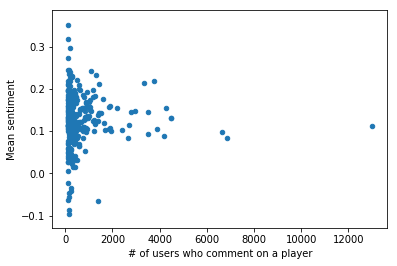

In [111]:
player_sentiment_df.query('user_count> 100 and season ==2017').plot('user_count', 'compound_mean_mean', kind='scatter')
#plt.plot([100, 100], [-0.1, 0.3])
plt.xlabel('# of users who comment on a player')
plt.ylabel('Mean sentiment')

#### Most commented players

In [123]:
player_sentiment_df.query('season ==2017').sort_values('user_count', ascending=False).head()

,fuzzy_name,season,compound_mean_mean,compound_mean_std,user_count
1271,lebron james,2017,0.113005,0.341995,13000
1157,kevin durant,2017,0.082803,0.379252,6838
835,james harden,2017,0.097981,0.365911,6635
1236,kyrie irving,2017,0.130130,0.383307,4491
1189,kobe bryant,2017,0.129677,0.381968,4475


#### Players with lowest sentiment
Sterling Brown's sentiment probably reflects a combination of sentiment towards police and himself. Other players on this list like Zaza Pachulia and Salah Mejri are well known disliked players.

In [124]:
player_sentiment_df.query('user_count > 200').sort_values('compound_mean_mean').head()

,fuzzy_name,season,compound_mean_mean,compound_mean_std,user_count
1452,mike dunleavy,2016,-0.108050,0.470797,238
1129,kelly olynyk,2016,-0.078625,0.468706,491
1870,steve blake,2015,-0.070948,0.441219,226
2124,zaza pachulia,2017,-0.066168,0.438263,1397
664,fred hoiberg,2016,-0.064798,0.455466,219


In [125]:
player_sentiment_df = player_sentiment_df.query('fuzzy_name != "sterling brown"')

#### Players with highest sentiment
This list seems biased towards players with relatively low comment counts

In [161]:
player_sentiment_df.query('user_count > 200').sort_values('compound_mean_mean').tail(5)

,fuzzy_name,season,compound_mean_mean,compound_mean_std,user_count
953,jj redick,2015.0,0.262868,0.355104,905
954,jj redick,2016.0,0.273153,0.351860,639
1655,rakeem christmas,2015.0,0.283326,0.411077,448
356,coty clarke,2017.0,0.295706,0.408073,209
197,brandon ingram,2015.0,0.304735,0.320630,202


#### Players with highest std of sentiment
Again, this appears biased towards players with relatively low comment counts.

In [127]:
player_sentiment_df.query('user_count > 200').sort_values('compound_mean_std').tail(5).iloc[::-1]

,fuzzy_name,season,compound_mean_mean,compound_mean_std,user_count
1166,kevin mchale,2017,0.056949,0.485148,222
1401,matt barnes,2016,0.001354,0.480636,244
1623,paul pierce,2017,0.031773,0.479982,424
1400,matt barnes,2015,0.020281,0.477218,262
1147,kenny atkinson,2016,0.100645,0.474739,272


## Explore demographics relationship with sentiment
#### Join player sentiment to performance and demographics
To see how sentiment is related to demographics, we can join the sentiment table above with the player demographics dataframe `covariates_df`.

I include only players with at least 50 comments to remove noise

In [202]:
join_df = (player_sentiment_df.rename(columns = {'fuzzy_name':'Player'})
                         .merge(covariates_df, on = ['Player', 'season'], how = 'left')
                          .drop(columns=['Unnamed: 19', 'Unnamed: 24'])).query('user_count > 10')

#### Sentiment versus performance
Surprisingly, there seems to be relatively little correlation between player performance and sentiment towards the player

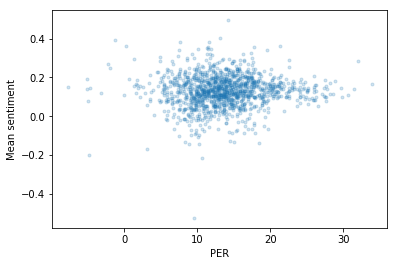

In [204]:
plt.plot(join_df['PER'].values, join_df['compound_mean_mean'].values, '.',alpha= 0.2);
plt.xlabel('PER')
plt.ylabel('Mean sentiment');

#### Sentiment and race
On average, sentiment towards black players is slightly lower than towards white players

In [205]:
join_df.groupby('Race').mean()

,season,compound_mean_mean,compound_mean_std,user_count,From,To,Ht,Wt,Rk,Age,G,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRBP,ASTP,STLP,BLKP,TOVP,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,ThreePP,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PPG,year,Wins,total_population,metro_percent_white,metro_percent_black,clinton_vote_lead,salary,standard_salary,experience
Race,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A,2016.250000,0.128102,0.415670,561.750000,2012.750000,2018.000000,77.500000,202.500000,312.500000,26.500000,33.250000,770.000000,12.700000,0.498000,0.365250,0.428000,2.250000,10.125000,6.225000,20.825000,1.125000,3.125000,17.100000,24.225000,0.525000,0.825000,1.325000,0.045250,-2.950000,-1.975000,-4.900000,0.275000,3.500000,8.550000,0.363750,0.925000,2.575000,0.328250,2.600000,5.975000,0.408500,0.412750,3.425000,3.825000,0.824500,0.275000,1.750000,2.050000,3.050000,0.500000,0.425000,1.975000,2.025000,11.350000,2017.250000,40.250000,1.223166e+07,62.875000,18.400000,0.414825,6.609467e+06,46.341010,4.500000
B,2016.042061,0.132069,0.419606,328.964248,2011.871714,2017.815983,78.396425,216.872766,248.553102,26.471083,56.335436,1333.842271,13.507045,0.531885,0.312508,0.262862,4.551209,14.635331,9.597581,13.565510,1.646688,1.641325,12.733789,19.128496,1.455626,1.346688,2.801367,0.081615,-1.034280,-0.315983,-1.349632,0.712408,3.429022,7.602944,0.445738,0.831651,2.364774,0.310016,2.597266,5.239432,0.487099,0.498559,1.551209,2.032492,0.746893,0.837539,2.843218,3.676866,2.042166,0.714616,0.419138,1.220715,1.760883,9.236698,2017.042061,41.245005,5.384480e+06,67.015142,15.732808,0.375736,6.277475e+06,44.447776,5.170347
L,2015.400000,0.033938,0.499258,95.800000,2009.200000,2016.800000,79.000000,234.200000,386.400000,30.600000,21.000000,230.000000,10.220000,0.491200,0.218800,0.550400,5.020000,13.520000,9.300000,21.820000,1.580000,1.220000,20.240000,14.600000,0.020000,0.220000,0.240000,0.072000,-3.300000,-0.840000,-4.120000,-0.140000,0.920000,2.580000,0.381000,0.220000,0.880000,0.145000,0.680000,1.720000,0.414000,0.406600,0.740000,0.940000,0.757800,0.360000,1.240000,1.580000,1.700000,0.300000,0.140000,0.700000,1.300000,2.740000,2016.400000,45.000000,6.124697e+06,65.400000,16.700000,0.457160,6.451792e+06,46.724175,7.200000
M,2015.955556,0.127546,0.422363,495.888889,2011.200000,2017.644444,77.288889,206.911111,267.288889,26.911111,58.066667,1526.444444,15.388889,0.535933,0.318800,0.226711,4.186667,13.591111,8.928889,19.986667,1.828889,1.104444,13.631111,21.120000,2.097778,1.491111,3.571111,0.096667,0.462222,-0.384444,0.068889,1.135556,4.435556,9.726667,0.448133,1.266667,3.348889,0.321682,3.171111,6.377778,0.478511,0.506533,1.742222,2.268889,0.753977,0.866667,3.046667,3.920000,3.146667,0.868889,0.320000,1.562222,1.866667,11.875556,2016.955556,42.066667,7.154136e+06,62.228889,11.260000,0.393618,9.333221e+06,49.562119,5.755556
R,2016.250000,0.034238,0.451719,105.750000,2016.500000,2018.000000,83.250000,241.250000,323.500000,28.500000,54.000000,638.250000,13.625000,0.592250,0.123250,0.444750,9.650000,22.100000,15.725000,5.150000,1.425000,5.875000,18.650000,13.625000,0.575000,1.125000,1.725000,0.119000,-3.575000,3.275000,-0.300000,0.300000,1.250000,2.375000,0.562000,0.125000,0.350000,0.171750,1.150000,2.025000,0.565750,0.582250,0.600000,1.025000,0.585750,1.050000,2.275000,3.325000,0.400000,0.325000,0.800000,0.625000,1.650000,3.275000,2017.250000,38.500000,6.400053e+06,71.600000,13.475000,0.292175,1.009611e+06,31.299630,0.750000
W,2016.020690,0.123835,0.416357,223.651724,2012.100000,2017.793103,81.375862,231.810345,249.527586,27.206897,56.779310,1191.841379,13.570345,0.549187,0.308382,0.266132,5.931034,17.207586,11.557241,11.390345,1.312069,1.820690,13.661806,17.718621,1.417241,1.251034,2.667931,0.093910,-1.137931,-0.180690,-1.314483,0.532759,2.868276,6.177931,0.462344,0.702069,1.909655,0.308914,2.166552,4.270000,0.499854,0.517715,1.230000,1.611379,0.751288,0.980000,2.951379,3.929310,1.532069,0.503793,0.42379

#### Sentiment and age / experience
Generally, sentiment seems to be higher for young and old players (where there is selection bias in that skilled / popular players have longer careers).

Text(0,0.5,'Mean sentiment')

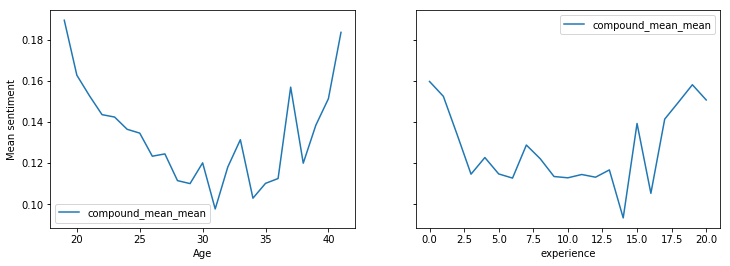

In [206]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = [12, 4], sharey=True)
join_df.groupby('Age').mean().reset_index().plot('Age', 'compound_mean_mean', ax = ax1);
join_df.groupby('experience').mean().reset_index().plot('experience', 'compound_mean_mean', ax = ax2);
ax1.set_ylabel('Mean sentiment')

#### Height

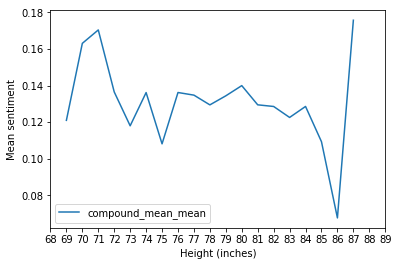

In [207]:
join_df.groupby('Ht').mean().reset_index().plot('Ht', 'compound_mean_mean');
plt.xticks(range(68,90,1) );
plt.xlabel('Height (inches)')
plt.ylabel('Mean sentiment');

### Team and position

In [209]:
join_df.groupby('Pos_y').mean().reset_index()

,Pos_y,season,compound_mean_mean,compound_mean_std,user_count,From,To,Ht,Wt,Rk,Age,G,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRBP,ASTP,STLP,BLKP,TOVP,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,ThreePP,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PPG,year,Wins,total_population,metro_percent_white,metro_percent_black,clinton_vote_lead,salary,standard_salary,experience
0,C,2016.045283,0.130005,0.415926,303.664151,2011.656604,2017.803774,83.120755,251.366038,258.656604,26.883019,56.550943,1194.626415,16.375094,0.568000,0.078566,0.368630,9.841509,22.140755,15.991698,9.101887,1.382264,3.596604,14.550566,18.235849,1.881509,1.651321,3.530943,0.125442,-1.513585,1.358868,-0.152453,0.933208,3.221509,6.144528,0.526328,0.198113,0.578868,0.193571,3.023396,5.566792,0.543238,0.538649,1.483774,2.169811,0.689019,1.681509,3.963396,5.643396,1.188302,0.515094,0.832453,1.122264,2.074717,8.122264,2017.045283,41.890566,5.642783e+06,66.917736,14.934340,0.393352,7.158837e+06,46.959251,5.388679
1,PF,2015.992337,0.127254,0.419990,297.482759,2011.858238,2017.793103,81.367816,236.015326,251.850575,26.452107,55.413793,1223.126437,13.765134,0.539653,0.299819,0.251923,6.643295,18.206130,12.418774,9.113027,1.336015,1.984674,12.004247,18.315709,1.347510,1.353640,2.701533,0.090628,-1.304981,-0.121456,-1.423755,0.609195,3.135249,6.736782,0.460135,0.678927,1.941762,0.309909,2.455939,4.802299,0.504384,0.511004,1.269732,1.709579,0.719295,1.105747,3.277395,4.378161,1.276245,0.534100,0.480843,0.980843,1.742912,8.219157,2016.992337,41.091954,5.497379e+06,67.578161,15.252874,0.378770,6.308577e+06,45.278257,5.134100
2,PF-C,2015.500000,0.153264,0.430524,136.500000,2010.500000,2018.000000,83.000000,237.500000,199.500000,28.500000,70.000000,1090.000000,12.750000,0.547500,0.484500,0.159000,5.600000,19.400000,12.500000,9.750000,1.250000,1.200000,11.900000,16.800000,1.000000,1.200000,2.250000,0.097000,-0.900000,-0.450000,-1.350000,0.200000,2.150000,4.900000,0.439000,0.900000,2.400000,0.362000,1.250000,2.500000,0.514000,0.529500,0.550000,0.750000,0.743500,0.750000,2.700000,3.450000,1.000000,0.400000,0.250000,0.700000,1.500000,5.750000,2016.500000,41.000000,1.832792e+06,72.650000,13.250000,0.175750,4.951374e+06,44.830567,6.000000
3,PG,2016.051661,0.125416,0.424562,322.553506,2012.084871,2017.749077,74.424354,189.011070,269.225092,26.656827,53.531365,1286.726937,13.526199,0.513812,0.335018,0.252439,2.156458,10.632841,6.384133,25.202583,1.882657,0.714022,15.514022,20.724723,1.489668,1.152030,2.640959,0.069657,-0.561255,-1.137269,-1.698893,0.739852,3.470849,8.110701,0.416594,0.951292,2.694465,0.325681,2.521402,5.411439,0.455145,0.472849,1.736162,2.143173,0.790336,0.436531,2.144280,2.581919,3.745387,0.818819,0.193727,1.603321,1.654613,9.622509,2017.051661,40.095941,5.390732e+06,67.173432,15.912177,0.361901,5.896532e+06,43.181477,4.966790
4,PG-SG,2017.000000,0.076169,0.416482,38.000000,2014.000000,2018.000000,72.000000,201.000000,84.000000,26.000000,20.000000,422.000000,13.500000,0.539000,0.482000,0.372000,1.500000,10.000000,5.700000,26.700000,1.800000,0.200000,15.400000,18.900000,0.500000,0.100000,0.600000,0.072000,0.100000,-2.500000,-2.400000,0.000000,2.600000,6.900000,0.380000,1.100000,3.300000,0.333000,1.500000,3.600000,0.423000,0.460000,2.300000,2.600000,0.902000,0.300000,2.000000,2.300000,3.800000,0.800000,0.100000,1.500000,1.800000,8.600000,2018.000000,21.000000,4.486153e+06,78.700000,5.200000,0.034500,1.113863e+06,32.486876,4.000000
5,SF,2015.978070,0.130242,0.417458,360.311404,2011.592105,2017.802632,79.539474,220.578947,231.592105,26.877193,58.285088,1415.412281,11.840789,0.523579,0.415053,0.225070,3.344737,13.854825,8.603070,9.872368,1.693860,1.257456,11.506579,17.642544,1.304386,1.378509,2.679825,0.070373,-1.140789,-0.253947,-1.394298,0.701754,3.223684,7.380702,0.421399,0.989912,2.835965,0.333761,2.233333,4.545614,0.480093,0.491193,1.436404,1.837281,0.760060,0.664474,2.775000,3.434649,1.550877,0.755263,0.338158,1.039474,1.717544,8.871053,2016.978070,41.

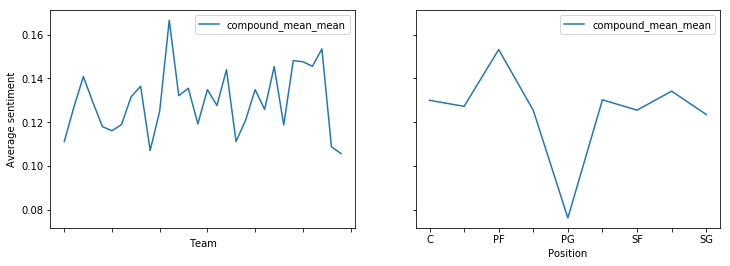

In [210]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = [12, 4], sharey=True)
join_df.groupby('Tm').mean().reset_index().plot('Tm', 'compound_mean_mean', ax = ax1);
ax1.set_xlabel('Team')
ax1.set_ylabel('Average sentiment')
join_df.groupby('Pos_y').mean().reset_index().plot('Pos_y', 'compound_mean_mean', ax = ax2);
ax2.set_xlabel('Position')
ax2.set_xticklabels(['', 'C','', 'PF','', 'PG','', 'SF','', 'SG']);

In [212]:
join_df.groupby('Tm').mean().sort_values('compound_mean_mean').head(2)

,season,compound_mean_mean,compound_mean_std,user_count,From,To,Ht,Wt,Rk,Age,G,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRBP,ASTP,STLP,BLKP,TOVP,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,ThreePP,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PPG,year,Wins,total_population,metro_percent_white,metro_percent_black,clinton_vote_lead,salary,standard_salary,experience
Tm,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
WAS,2015.952381,0.105611,0.416034,225.095238,2011.261905,2017.761905,79.071429,218.047619,282.52381,27.285714,59.238095,1377.142857,13.223810,0.535585,0.295171,0.257585,4.523810,17.188095,10.978571,13.273810,1.592857,1.390476,12.465854,18.419048,1.635714,1.404762,3.026190,0.086690,-1.357143,-0.433333,-1.790476,0.759524,3.388095,7.35000,0.451610,0.769048,2.150000,0.298359,2.614286,5.207143,0.49078,0.502024,1.447619,1.911905,0.749585,0.828571,2.800000,3.630952,2.116667,0.723810,0.354762,1.17619,1.869048,8.990476,2016.952381,44.285714,6011752.0,55.1,25.4,0.3622,6.990124e+06,47.099275,5.690476
GSW,2016.021739,0.107044,0.417490,866.260870,2010.434783,2017.847826,79.804348,223.391304,252.50000,27.608696,61.739130,1283.456522,15.795652,0.578000,0.240652,0.278261,6.391304,15.613043,11.286957,14.102174,1.586957,2.489130,14.258696,18.250000,2.441304,1.741304,4.176087,0.141543,0.097826,0.436957,0.541304,1.376087,3.360870,6.76087,0.505478,0.910870,2.315217,0.326738,2.434783,4.445652,0.54387,0.550870,1.345652,1.732609,0.728822,0.804348,2.854348,3.643478,2.276087,0.671739,0.550000,1.16087,1.636957,8.989130,2017.021739,65.826087,4577530.0,52.1,7.6,0.6444,7.378940e+06,46.345483,6.586957


#### Create modeling dataframe

In [164]:
join_df['youth'] = (join_df['Age'].mean() - join_df['Age']).clip(0)
join_df['oldness'] = (join_df['Age'] - join_df['Age'].mean()).clip(0)
join_df['rookie'] = join_df['experience'] <=4

In [165]:
join_df['ThreePP'] =join_df['ThreePP'].fillna(join_df['ThreePP'].mean())
join_df['white_black_diff'] = join_df['metro_percent_white'] - join_df['metro_percent_black']

In [166]:
join_df['height_dummies'] = pd.cut(join_df['Ht'], [0, 72, 79, 100], labels = ['short', 'medium', 'tall'])

In [179]:
#join_df.to_csv('modeling_data/nba_model_data.tsv', sep='\t', index=False)
join_df = pd.read_csv('modeling_data/nba_model_data.tsv', sep='\t')

In [168]:
fit_df = join_df.replace({'M':'B', 'L':'W'}).query('Race == "W" or Race == "B"').query('user_count > 20')#

In [169]:
fit_df.head(2)

,Player,season,compound_mean_mean,compound_mean_std,user_count,Race,From,To,Pos_x,Ht,Wt,Birth Date,Colleges,Rk,Pos_y,Age,G,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRBP,ASTP,STLP,BLKP,TOVP,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Tm,FG,FGA,FG%,3P,3PA,ThreePP,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PPG,year,Wins,total_population,metro_percent_white,metro_percent_black,clinton_vote_lead,salary,standard_salary,experience,youth,oldness,rookie,white_black_diff,height_dummies
0,aaron brooks,2015,-0.012463,0.445493,33,B,2008.0,2018.0,G,72.0,161.0,"January 14, 1985",University of Oregon,62.0,PG,31.0,69.0,1108.0,11.8,0.494,0.394,0.136,2.0,7.5,4.8,26.0,1.4,0.7,14.2,22.9,0.2,0.7,0.9,0.040,-0.5,-2.8,-3.3,-0.4,CHI,2.7,6.8,0.401,1.0,2.7,0.357,1.8,4.1,0.430,0.471,0.7,0.9,0.766,0.3,1.2,1.5,2.6,0.4,0.1,1.2,1.9,7.1,2016.0,42.0,9528396.0,66.3,16.9,0.5296,2250000.0,38.729833,8.0,0.0,4.323575,False,49.4,short
2,aaron brooks,2017,0.114652,0.475071,31,B,2008.0,2018.0,G,72.0,161.0,"January 14, 1985",University of Oregon,65.0,PG,33.0,32.0,189.0,9.8,0.508,0.449,0.159,4.2,6.2,5.2,15.1,1.6,0.0,13.0,19.9,0.1,0.1,0.1,0.033,-0.8,-3.6,-4.3,-0.1,MIN,0.9,2.2,0.406,0.3,1.0,0.355,0.5,1.2,0.447,0.486,0.3,0.3,0.727,0.2,0.3,0.5,0.6,0.2,0.0,0.3,0.9,2.3,2018.0,47.0,3488436.0,80.3,7.8,0.3531,2116955.0,38.144147,10.0,0.0,6.323575,False,72.5,short


## Regression models

### Salary

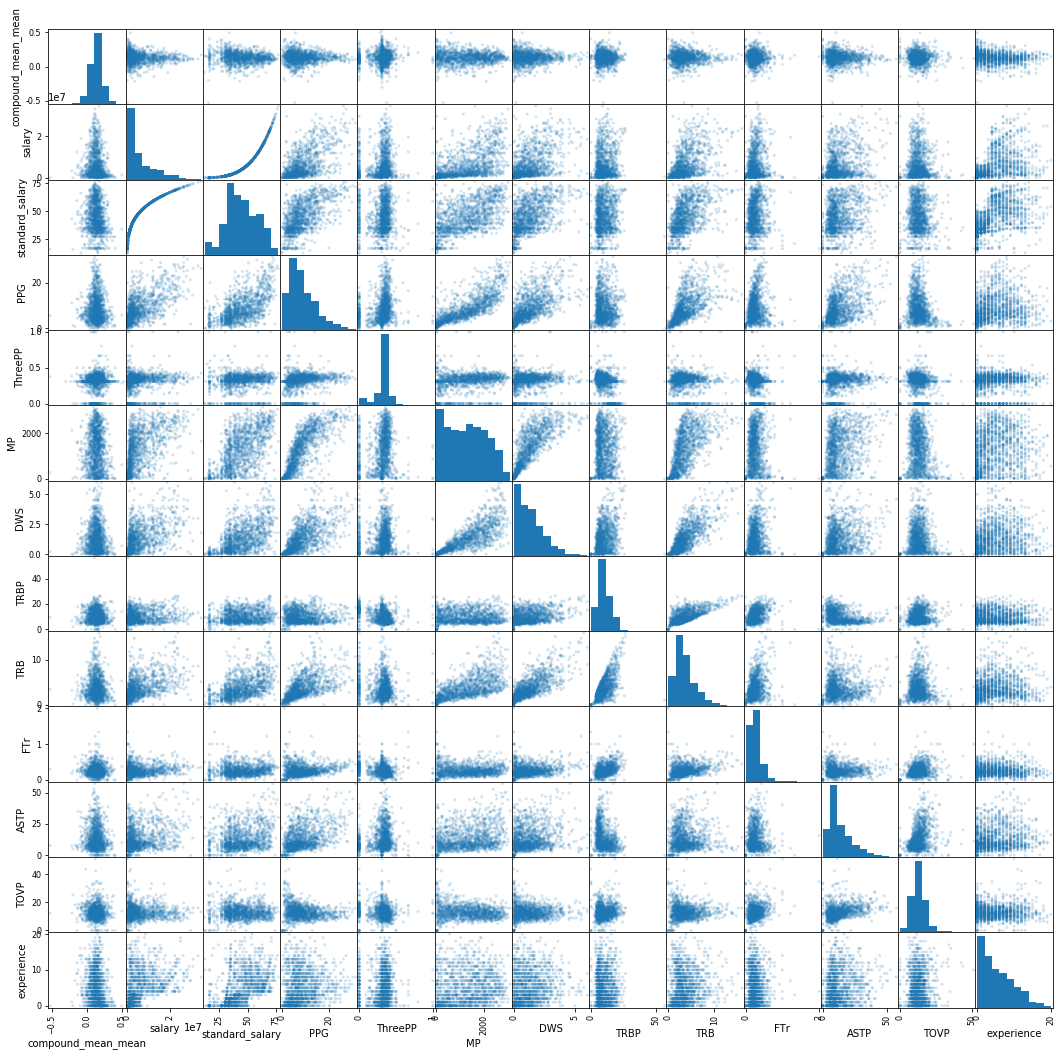

In [171]:
from pandas.plotting import scatter_matrix
scatter_matrix(join_df[['compound_mean_mean', 'salary', 'standard_salary', 'PPG',
                        'ThreePP', 'MP', 'DWS', 'TRBP', 'TRB', 'FTr', 'ASTP', 'TOVP', 'experience']], alpha=0.2, figsize=(18, 18));

In [172]:
salary_model = smf.wls( formula = 'standard_salary ~ rookie + MP + PPG + ThreePP + DWS + TRBP * height_dummies + AST + BLKP * height_dummies + STLP + TOVP',
                data = fit_df,
               weights = fit_df['G'],
#                missing='raise'   
               ).fit()

In [173]:
salary_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:        standard_salary   R-squared:                       0.551
Model:                            WLS   Adj. R-squared:                  0.544
Method:                 Least Squares   F-statistic:                     83.85
Date:                Mon, 05 Nov 2018   Prob (F-statistic):          3.56e-177
Time:                        17:43:06   Log-Likelihood:                -3992.6
No. Observations:                1111   AIC:                             8019.
Df Residuals:                    1094   BIC:                             8104.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        21.0526      5.754      3.659      0.000       9.762      32.343
rookie[T.True]                   -9.9340      0.510    -19.482      0.000     -10.935      -8.934
height_dummies[T.medium]         19.3484      5.524      3.503      0.000       8.509      30.187
height_dummies[T.tall]           19.2255      5.530      3.476      0.001       8.374      30.077
MP                                0.0026      0.001      3.676      0.000       0.001       0.004
PPG                               0.6872      0.082      8.352      0.000       0.526       0.849
ThreePP                          -2.9235      2.373     -1.232      0.218      -7.579       1.732
DWS                               0.5274      0.444      1.189      0.235      -0.343       1.398
TRBP                              3.1818      0.981      3.243      0.001       1.257       5.107
TRBP:height_dummies[T.medium]    -3.3759      0.992     -3.405      0.001      -5.322      -1.430
TRBP:height_dummies[T.tall]      -2.8690      0.985     -2.911      0.004      -4.803      -0.935
AST                               0.5680      0.248      2.290      0.022       0.081       1.055
BLKP                             -6.4950      4.981     -1.304      0.193     -16.268       3.278
BLKP:height_dummies[T.medium]     7.8555      5.012      1.567      0.117      -1.979      17.690
BLKP:height_dummies[T.tall]       5.7622      4.983      1.156      0.248      -4.016      15.540
STLP                             -1.1958      0.501     -2.385      0.017      -2.180      -0.212
TOVP                              0.0442      0.085      0.519      0.604      -0.123       0.212
==============================================================================
Omnibus:                        3.620   Durbin-Watson:                   1.713
Prob(Omnibus):                  0.164   Jarque-Bera (JB):                3.500
Skew:                           0.116   Prob(JB):                        0.174
Kurtosis:                       3.148   Cond. No.                     6.93e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.93e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Calculate residual salary

In [174]:
fit_df['pred_std_salary'] = salary_model.predict(fit_df)
fit_df['std_salary_resid'] = fit_df['pred_std_salary']- fit_df['standard_salary']
fit_df.sort_values('std_salary_resid').head(5)[['Player', 'season', 'standard_salary', 'pred_std_salary', 'MP', 'PPG', 'G']]

,Player,season,standard_salary,pred_std_salary,MP,PPG,G
1848,solomon hill,2017,59.144534,30.308809,187.0,2.4,12.0
713,gordon hayward,2017,73.839893,45.074880,5.0,2.0,1.0
1318,luol deng,2017,64.390081,38.398758,13.0,2.0,1.0
1478,miles plumlee,2016,59.341077,33.373180,484.0,2.5,45.0
53,allen crabbe,2016,65.583250,42.439458,2254.0,10.7,79.0


There is a big problem using rate states where low sample size is causing funky predicted salary. I think the best way to handle this would be to shrink the salary residuals based on # of games played, but I'm not 100% sure how to do that. So I will set the salary residual for all players with < 20 games to be 0.

In [175]:
fit_df.loc[ fit_df['G'] <20, 'std_salary_resid'] = 0
fit_df.sort_values('std_salary_resid').head(5)[['Player', 'season', 'standard_salary', 'pred_std_salary', 'MP', 'PPG', 'G']]

,Player,season,standard_salary,pred_std_salary,MP,PPG,G
1478,miles plumlee,2016,59.341077,33.373180,484.0,2.5,45.0
53,allen crabbe,2016,65.583250,42.439458,2254.0,10.7,79.0
1590,otto porter,2017,70.549793,48.238770,2432.0,14.7,77.0
344,cody zeller,2017,59.560318,37.864173,627.0,7.1,33.0
716,gorgui dieng,2017,61.291452,39.658972,1333.0,5.9,79.0


Most underpaid players

In [176]:
fit_df.sort_values('std_salary_resid', ascending=False).head(5)[['Player', 'season', 'standard_salary', 'pred_std_salary', 'MP', 'PPG', 'G']]

,Player,season,standard_salary,pred_std_salary,MP,PPG,G
1433,michael beasley,2015,23.529724,51.418882,363.0,12.8,20.0
1457,mike james,2017,20.148403,47.836280,687.0,9.3,36.0
735,hassan whiteside,2015,31.474277,57.165261,2125.0,14.2,73.0
2048,tyrone wallace,2017,16.671498,39.542271,851.0,9.7,30.0
1555,nikola jokic,2017,34.828226,56.090588,2443.0,18.5,75.0


### Sentiment regression models
First, a regression model for sentiment with features for performance, age, team wins, race, and height.

In [177]:
'''model = sm.WLS( fit_df['compound_mean_mean'].values,
               fit_df[['youth', 'oldness', 'Wins', 'W', 'M', 'short', 'tall',
                       'PS/G', '3P%' , 'TRB%', 'AST%','BLK%', 'STL%', 'OWS', 'DWS']],
               fit_df['user_count']).fit()'''
model = smf.wls( formula = 'compound_mean_mean ~ youth + oldness + Wins + C(height_dummies) + ' \
                       'MP + PPG + std_salary_resid + ThreePP + DWS + TRB + FTr+ AST + BLKP + STLP + TOV + total_population+ C(Race) * white_black_diff + C(Race) * clinton_vote_lead',
                data = fit_df,
               weights = 1 / (fit_df['compound_mean_std'] / np.sqrt(fit_df['user_count'])),
#                missing='raise'   
               ).fit()

In [178]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:     compound_mean_mean   R-squared:                       0.113
Model:                            WLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     6.345
Date:                Mon, 05 Nov 2018   Prob (F-statistic):           8.73e-18
Time:                        17:43:08   Log-Likelihood:                 1442.3
No. Observations:                1115   AIC:                            -2839.
Df Residuals:                    1092   BIC:                            -2723.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                          0.1337      0.020      6.695      0.000       0.095       0.173
C(height_dummies)[T.medium]       -0.0127      0.011     -1.183      0.237      -0.034       0.008
C(height_dummies)[T.tall]         -0.0126      0.012     -1.083      0.279      -0.035       0.010
C(Race)[T.W]                      -0.0067      0.022     -0.311      0.756      -0.049       0.036
youth                              0.0080      0.001      8.012      0.000       0.006       0.010
oldness                            0.0018      0.001      2.592      0.010       0.000       0.003
Wins                              -0.0005      0.000     -2.367      0.018      -0.001   -7.71e-05
MP                             -7.995e-06    4.8e-06     -1.664      0.096   -1.74e-05    1.43e-06
PPG                                0.0024      0.001      4.291      0.000       0.001       0.003
std_salary_resid                   0.0004      0.000      1.555      0.120   -9.41e-05       0.001
ThreePP                            0.0382      0.016      2.402      0.016       0.007       0.069
DWS                                0.0102      0.004      2.784      0.005       0.003       0.017
TRB                               -0.0046      0.001     -3.229      0.001      -0.007      -0.002
FTr                                0.0043      0.014      0.298      0.766      -0.024       0.032
AST                               -0.0005      0.002     -0.267      0.789      -0.004       0.003
BLKP                               0.0009      0.002      0.583      0.560      -0.002       0.004
STLP                               0.0005      0.003      0.182      0.856      -0.005       0.006
TOV                               -0.0130      0.005     -2.416      0.016      -0.024      -0.002
total_population               -2.608e-11   4.63e-10     -0.056      0.955   -9.35e-10    8.83e-10
white_black_diff                 1.08e-05      0.000      0.077      0.938      -0.000       0.000
C(Race)[T.W]:white_black_diff      0.0003      0.000      1.140      0.255      -0.000       0.001
clinton_vote_lead                  0.0075      0.013      0.592      0.554      -0.017       0.032
C(Race)[T.W]:clinton_vote_lead    -0.0243      0.024     -1.018      0.309      -0.071       0.023
==============================================================================
Omnibus:                       49.153   Durbin-Watson:                   1.566
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               91.482
Skew:                          -0.314   Prob(JB):                     1.36e-20
Kurtosis:                       4.255   Cond. No.                     1.25e+08
==============================================================================

Warnings:
[1] Standard Errors assu

In [307]:
predicted_senti = model.predict(fit_df[['PER', 'youth', 'oldness', 'Wins', 'W', 'M', 'short', 'tall']])

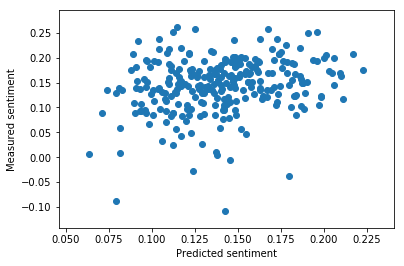

In [308]:
plt.scatter(predicted_senti, fit_df['compound_mean_mean'])
plt.xlabel('Predicted sentiment')
plt.ylabel('Measured sentiment');

## Coaches

In [104]:
coaches_df = pd.read_csv('d:/data/sentiment_sports/covariates/nba_coach_performance.tsv', sep='\t')
coaches_race_df = pd.read_csv('d:/data/sentiment_sports/covariates/nba_coach_race.tsv', sep='\t')
coaches_df['Tm'] = coaches_df['Tm'].replace({'CHA':'CHO'})

In [105]:
team_win_df = coaches_df.groupby(['Tm', 'season']).sum()['W'].reset_index()
team_win_df['season_WinP_prev'] = team_win_df['W'] / 82

In [106]:
coach_tenure = coaches_df.groupby(['Tm', 'Coach']).apply(lambda df: df.rank())[['season']].rename(columns={'season':'tenure'})
coaches_df = coaches_df.join(coach_tenure)
coaches_df['rookie'] = coaches_df['tenure'] == 1

In [107]:
coaches_df['prev_season'] = coaches_df['season']-1
coaches_df = coaches_df.merge(team_win_df.rename(columns = {'season': 'prev_season'}),
                              on = ['prev_season', 'Tm'], how='left', suffixes = ('', '_prev') )
coaches_df['winP_change'] = (coaches_df['season_WinP'] - coaches_df['season_WinP_prev']).fillna(0)

In [108]:
coaches_covariates_df = (coaches_df.merge(coaches_race_df, on = 'Coach')
                                   .rename(columns = {'Coach':'fuzzy_name'})
                                   .merge(player_sentiment_df, on = ['fuzzy_name', 'season'], how='inner')
                                   )

### Most and least popular coaches

In [109]:
coaches_covariates_df.sort_values('compound_mean_mean',ascending=False).head(5)

,season,age,league,Tm,G,W,L,season_WinP,career_WinP,fuzzy_name,tenure,rookie,prev_season,W_prev,season_WinP_prev,winP_change,race,compound_mean_mean,compound_mean_std,user_count
122,2015,36.0,NBA,PHO,33,9.0,24.0,0.273,0.280,earl watson,1.0,True,2014,39.0,0.475610,-0.202610,B,0.338633,0.410939,9
99,2014,38.0,NBA,BOS,82,40.0,42.0,0.488,0.540,brad stevens,2.0,False,2013,25.0,0.304878,0.183122,W,0.305777,0.379385,224
6,2014,NaN,NBA,ORL,30,10.0,20.0,0.333,0.381,james borrego,1.0,True,2013,23.0,0.280488,0.052512,W,0.297263,0.406171,15
12,2015,46.0,NBA,ATL,82,48.0,34.0,0.585,0.526,mike budenholzer,3.0,False,2014,60.0,0.731707,-0.146707,W,0.270911,0.367624,19
100,2015,39.0,NBA,BOS,82,48.0,34.0,0.585,0.540,brad stevens,3.0,False,2014,40.0,0.487805,0.097195,W,0.258842,0.404331,342


In [110]:
coaches_covariates_df.sort_values('compound_mean_mean',ascending=False).tail(5)

,season,age,league,Tm,G,W,L,season_WinP,career_WinP,fuzzy_name,tenure,rookie,prev_season,W_prev,season_WinP_prev,winP_change,race,compound_mean_mean,compound_mean_std,user_count
115,2014,39.0,NBA,ORL,52,15.0,37.0,0.288,0.269,jacque vaughn,3.0,False,2013,23.0,0.280488,0.007512,B,-0.062298,0.400476,20
41,2016,44.0,NBA,CHI,82,41.0,41.0,0.500,0.440,fred hoiberg,2.0,False,2015,42.0,0.512195,-0.012195,B,-0.064798,0.455466,219
75,2015,52.0,NBA,MIN,82,29.0,53.0,0.354,0.433,sam mitchell,1.0,True,2014,16.0,0.195122,0.158878,B,-0.072697,0.426356,131
124,2017,38.0,NBA,PHO,3,0.0,3.0,0.000,0.280,earl watson,3.0,False,2016,24.0,0.292683,-0.292683,B,-0.111139,0.465846,57
10,2015,55.0,NBA,BRK,45,11.0,34.0,0.244,0.244,tony brown,1.0,True,2014,38.0,0.463415,-0.219415,B,-0.680800,NaN,1


### Filter to coaches with enough games and comments and explore data

In [122]:
coaches_fit_df = coaches_covariates_df.query('G >= 10 and user_count > 10')
coaches_fit_df['age'] = coaches_fit_df['age'].fillna(coaches_fit_df['age'].mean())
coaches_covariates_df.to_csv('modeling_data/nba_coaches_covariates.tsv', sep='\t', index=False)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


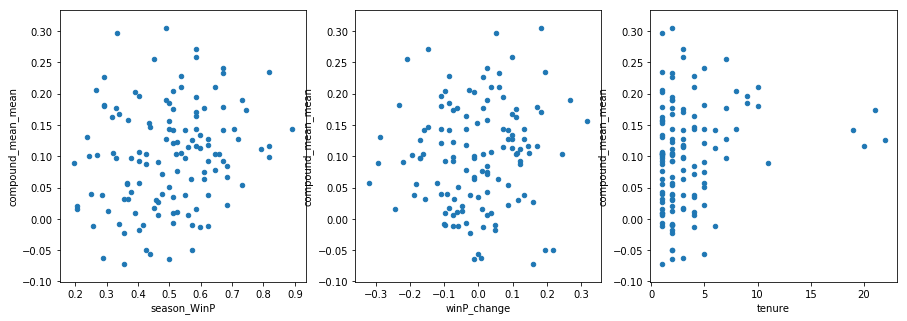

In [112]:
fig, axes = plt.subplots(1,3, figsize = [15, 5])
coaches_fit_df.plot.scatter('season_WinP', 'compound_mean_mean', ax = axes[0]);
coaches_fit_df.plot.scatter('winP_change', 'compound_mean_mean', ax = axes[1]);
coaches_fit_df.plot.scatter('tenure', 'compound_mean_mean', ax = axes[2]);

In [113]:
coaches_fit_df.groupby('race').agg(['mean', 'count'])['compound_mean_mean']

,mean,count
race,,
B,0.057023,40
W,0.121204,85


#### Coaches model - no clustering

In [114]:
'''model = sm.WLS( fit_df['compound_mean_mean'].values,
               fit_df[['youth', 'oldness', 'Wins', 'W', 'M', 'short', 'tall',
                       'PS/G', '3P%' , 'TRB%', 'AST%','BLK%', 'STL%', 'OWS', 'DWS']],
               fit_df['user_count']).fit()'''
coach_model = smf.wls( formula = 'compound_mean_mean ~ age + tenure + rookie + career_WinP + winP_change +season_WinP + C(race)',
                data = coaches_fit_df,
               weights = 1 / (coaches_fit_df['compound_mean_std'] / np.sqrt(coaches_fit_df['user_count'])),
#                missing='raise'   
               ).fit()

In [115]:
coach_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:     compound_mean_mean   R-squared:                       0.357
Model:                            WLS   Adj. R-squared:                  0.317
Method:                 Least Squares   F-statistic:                     8.873
Date:                Sun, 11 Nov 2018   Prob (F-statistic):           1.17e-08
Time:                        11:27:48   Log-Likelihood:                 150.11
No. Observations:                 120   AIC:                            -284.2
Df Residuals:                     112   BIC:                            -261.9
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.1817      0.049      3.708      0.000       0.085       0.279
rookie[T.True]     0.0147      0.017      0.869      0.386      -0.019       0.048
C(race)[T.W]       0.0658      0.014      4.695      0.000       0.038       0.094
age               -0.0041      0.001     -4.612      0.000      -0.006      -0.002
tenure             0.0064      0.002      3.103      0.002       0.002       0.010
career_WinP        0.0472      0.093      0.506      0.614      -0.138       0.232
winP_change        0.0477      0.066      0.728      0.468      -0.082       0.178
season_WinP        0.0627      0.072      0.869      0.387      -0.080       0.206
==============================================================================
Omnibus:                        1.434   Durbin-Watson:                   1.787
Prob(Omnibus):                  0.488   Jarque-Bera (JB):                1.202
Skew:                           0.004   Prob(JB):                        0.548
Kurtosis:                       2.510   Cond. No.                         996.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Coaches model - with clustered errors

In [123]:
'''model = sm.WLS( fit_df['compound_mean_mean'].values,
               fit_df[['youth', 'oldness', 'Wins', 'W', 'M', 'short', 'tall',
                       'PS/G', '3P%' , 'TRB%', 'AST%','BLK%', 'STL%', 'OWS', 'DWS']],
               fit_df['user_count']).fit()'''
coach_model_clustered = smf.wls( formula = 'compound_mean_mean ~ age + tenure + rookie + career_WinP + winP_change +season_WinP + C(race)',
                data = coaches_fit_df,
               weights = 1 / (coaches_fit_df['compound_mean_std'] / np.sqrt(coaches_fit_df['user_count'])),
#                missing='raise'   
               ).fit(cov_type='cluster', cov_kwds={'groups' : coaches_fit_df['fuzzy_name']})

In [124]:
coach_model_clustered.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:     compound_mean_mean   R-squared:                       0.348
Model:                            WLS   Adj. R-squared:                  0.309
Method:                 Least Squares   F-statistic:                     6.112
Date:                Sun, 11 Nov 2018   Prob (F-statistic):           3.93e-05
Time:                        11:31:46   Log-Likelihood:                 156.86
No. Observations:                 125   AIC:                            -297.7
Df Residuals:                     117   BIC:                            -275.1
Df Model:                           7                                         
Covariance Type:              cluster                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.1801      0.078      2.311      0.021       0.027       0.333
rookie[T.True]     0.0185      0.015      1.239      0.215      -0.011       0.048
C(race)[T.W]       0.0660      0.016      4.040      0.000       0.034       0.098
age               -0.0041      0.001     -2.898      0.004      -0.007      -0.001
tenure             0.0065      0.002      2.655      0.008       0.002       0.011
career_WinP        0.0405      0.089      0.457      0.648      -0.133       0.214
winP_change        0.0398      0.073      0.548      0.583      -0.102       0.182
season_WinP        0.0689      0.061      1.134      0.257      -0.050       0.188
==============================================================================
Omnibus:                        1.633   Durbin-Watson:                   1.832
Prob(Omnibus):                  0.442   Jarque-Bera (JB):                1.317
Skew:                           0.028   Prob(JB):                        0.518
Kurtosis:                       2.500   Cond. No.                     1.01e+03
==============================================================================

Warnings:
[1] Standard Errors are robust tocluster correlation (cluster)
[2] The condition number is large, 1.01e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""